In [38]:
import polars as pl
from typing import Iterable, Union, Optional,Sequence
import time
import psutil
import os

from sklearn.model_selection import KFold
from sklearn.ensemble import VotingRegressor

import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
import gc


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import shap
import pickle
import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)   # tüm kolonları göster
pd.set_option('display.width', None)         # genişliği kısıtlama (auto-detect)
pd.set_option('display.max_colwidth', None)  # hücre içeriğini kesme


## 1. Verilerin Okunması

In [3]:
DATA_PATH = "/Users/kerimcanarslan/Desktop/JupyterLab/Trendyol Hackhaton/data"

DATA_PREP = False
FEATURE_SELECTION = False

In [4]:
# --- TRAIN (lazy) ---
train = pl.scan_parquet(f"{DATA_PATH}/train_sessions.parquet").select([
    "ts_hour","search_term_normalized","clicked","ordered","user_id_hashed","content_id_hashed","session_id"
    ])

# TRAIN: --- Tarih formatlarını veri işlemeye hazır hale getiriyoruz. ---
train = train.with_columns(
    ts_hour_dt = pl.col("ts_hour").cast(pl.Datetime),
).with_columns([
    pl.col("ts_hour_dt").cast(pl.Date).alias("ts_date"),
    (pl.col("ts_hour_dt").cast(pl.Date) - pl.duration(days=1)).alias("ts_date_1"),
    (pl.col("ts_hour_dt") - pl.duration(days=1, hours=1)).alias("ts_date_25h"),
    pl.lit("train").alias("split"),
]).select(pl.all().exclude("ts_hour_dt"))

# --- TEST (lazy) ---
test = pl.scan_parquet(f"{DATA_PATH}/test_sessions.parquet").with_columns(
    ts_hour_dt = pl.col("ts_hour").cast(pl.Datetime),
).with_columns([
    pl.col("ts_hour_dt").cast(pl.Date).alias("ts_date"),
    (pl.col("ts_hour_dt").cast(pl.Date) - pl.duration(days=1)).alias("ts_date_1"),
    (pl.col("ts_hour_dt") - pl.duration(days=1, hours=1)).alias("ts_date_25h"),
    pl.lit("test").alias("split"),
]).select(pl.all().exclude("ts_hour_dt"))

# --- CONTENT DATASETS (lazy) ---
content_metadata = (
    pl.scan_parquet(f"{DATA_PATH}/content/metadata.parquet")
      .with_columns(pl.col("content_creation_date").cast(pl.Date))
)

content_price_data = (
    pl.scan_parquet(f"{DATA_PATH}/content/price_rate_review_data.parquet")
      .with_columns(pl.col("update_date").cast(pl.Date).alias("ts_date"))
      .drop("update_date")
)

content_search_log = (
    pl.scan_parquet(f"{DATA_PATH}/content/search_log.parquet")
      .with_columns(pl.col("date").cast(pl.Date))
)

content_sitewide_log = (
    pl.scan_parquet(f"{DATA_PATH}/content/sitewide_log.parquet")
      .with_columns(pl.col("date").cast(pl.Date))
)

content_top_terms_log = (
    pl.scan_parquet(f"{DATA_PATH}/content/top_terms_log.parquet")
      .with_columns(pl.col("date").cast(pl.Date))
)

# --- TERM DATASET (lazy) ---
term_search_log = (
    pl.scan_parquet(f"{DATA_PATH}/term/search_log.parquet")
      .with_columns([
          pl.col("ts_hour").cast(pl.Datetime).alias("ts_hour_dt"),
          pl.col("ts_hour").cast(pl.Datetime).cast(pl.Date).alias("ts_date"),
      ]).select(pl.all().exclude("ts_hour_dt"))
)

# --- USER DATASETS (lazy) ---
user_metadata = (
    pl.scan_parquet(f"{DATA_PATH}/user/metadata.parquet")
)

user_fashion_search_log = (
    pl.scan_parquet(f"{DATA_PATH}/user/fashion_search_log.parquet")
      .with_columns(
          # ts_hour zaten Datetime ise ilk cast opsiyonel
          pl.col("ts_hour").cast(pl.Datetime).cast(pl.Date).alias("ts_date")
      )
)

user_fashion_sitewide_log = (
    pl.scan_parquet(f"{DATA_PATH}/user/fashion_sitewide_log.parquet")
      .with_columns(
          # ts_hour zaten Datetime ise ilk cast opsiyonel
          pl.col("ts_hour").cast(pl.Datetime).cast(pl.Date).alias("ts_date")
      )
)

user_search_log = (
    pl.scan_parquet(f"{DATA_PATH}/user/search_log.parquet"))


user_sitewide_log = (
    pl.scan_parquet(f"{DATA_PATH}/user/sitewide_log.parquet"))


user_top_terms_log = (
    pl.scan_parquet(f"{DATA_PATH}/user/top_terms_log.parquet"))

In [5]:
# --- Yapılacak tüm Feature Engineering işlemlerini test setine de uygulamak için datayı birleştiriyoruz ---
df_all = pl.concat([train, test], how="diagonal")

## 2. Veri Analizi

### 2.1. Train-Test Datasının Dağılımı
Train datasında sadece 3 günlük bir verinin 1 saatlik bir zaman diliminde olduğunu görüyoruz.
Test datasında ise sadece 1 günlük bir veri tercih edilmiş. 

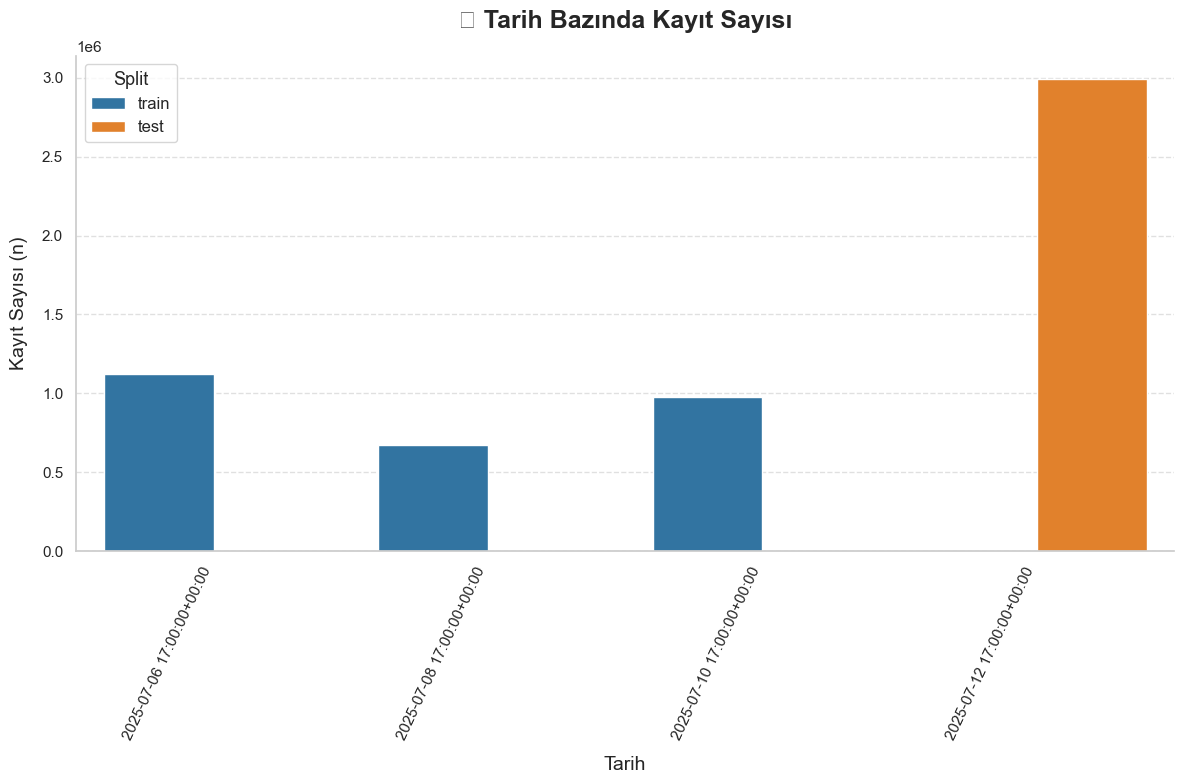

In [6]:
vc = ( df_all .group_by(["ts_hour", "split"]) .len(name="n") .sort(["ts_hour", "n"], descending=[False, True]) .collect() .to_pandas() )

sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=vc,
    x="ts_hour",
    y="n",
    hue="split",
    palette={"train": "#1f77b4", "test": "#ff7f0e"}, 
    dodge=True
)

plt.title("📊 Tarih Bazında Kayıt Sayısı", fontsize=18, weight="bold", pad=20)
plt.xlabel("Tarih", fontsize=14, labelpad=10)
plt.ylabel("Kayıt Sayısı (n)", fontsize=14, labelpad=10)
plt.xticks(rotation=65, ha="right")

ax.yaxis.grid(True, linestyle="--", alpha=0.6)
ax.set_axisbelow(True)

plt.legend(title="Split", fontsize=12, title_fontsize=13, loc="upper left", frameon=True)

sns.despine()

plt.tight_layout()
plt.show()


### 2.2. Content-Term-User Datasının Dağılımı

Train ve Test datasında ilgili günlerin tek bir saati (**17:00**) verilmişti.  
Test datası sadece **2025-07-12 17:00** tarihinden oluşuyor.  

Fakat Content-Term-User **Log** verileri incelendiğinde maksimum **2025-07-11 16:00** tarihine ait veriler bulunmakta.  


In [7]:
# --- Örnek bir tablo ---

term_search_log.select(pl.col("ts_hour").max()).collect()

ts_hour
"datetime[μs, UTC]"
2025-07-11 16:00:00 UTC


Bu sebeple;
* **term_search_log**,  
* **user_fashion_search_log**,  
* **user_fashion_sitewide_log**,  
* **user_search_log**,  
* **user_sitewide_log**,  
* **user_top_terms_log**  

tabloları, train-test verileri ile **t-25 saat lag** kullanılarak joinlenmelidir.

### 2.3. Log Tabloları

Log tabloları saatlik bazda tutulmuş. Hem ürün hem de user bilgilerinin saatlik ya da günlük log'ları mevcut. 
Elimideki verilerde yaklaşık son 1 aylık log bilgisinin olduğunu görüyoruz.

In [8]:
date_range = (
    content_search_log
    .select([
        pl.col("date").min().alias("min_date"),
        pl.col("date").max().alias("max_date")
    ])
    .collect()
)

print(date_range)

shape: (1, 2)
┌────────────┬────────────┐
│ min_date   ┆ max_date   │
│ ---        ┆ ---        │
│ date       ┆ date       │
╞════════════╪════════════╡
│ 2025-06-07 ┆ 2025-07-11 │
└────────────┴────────────┘


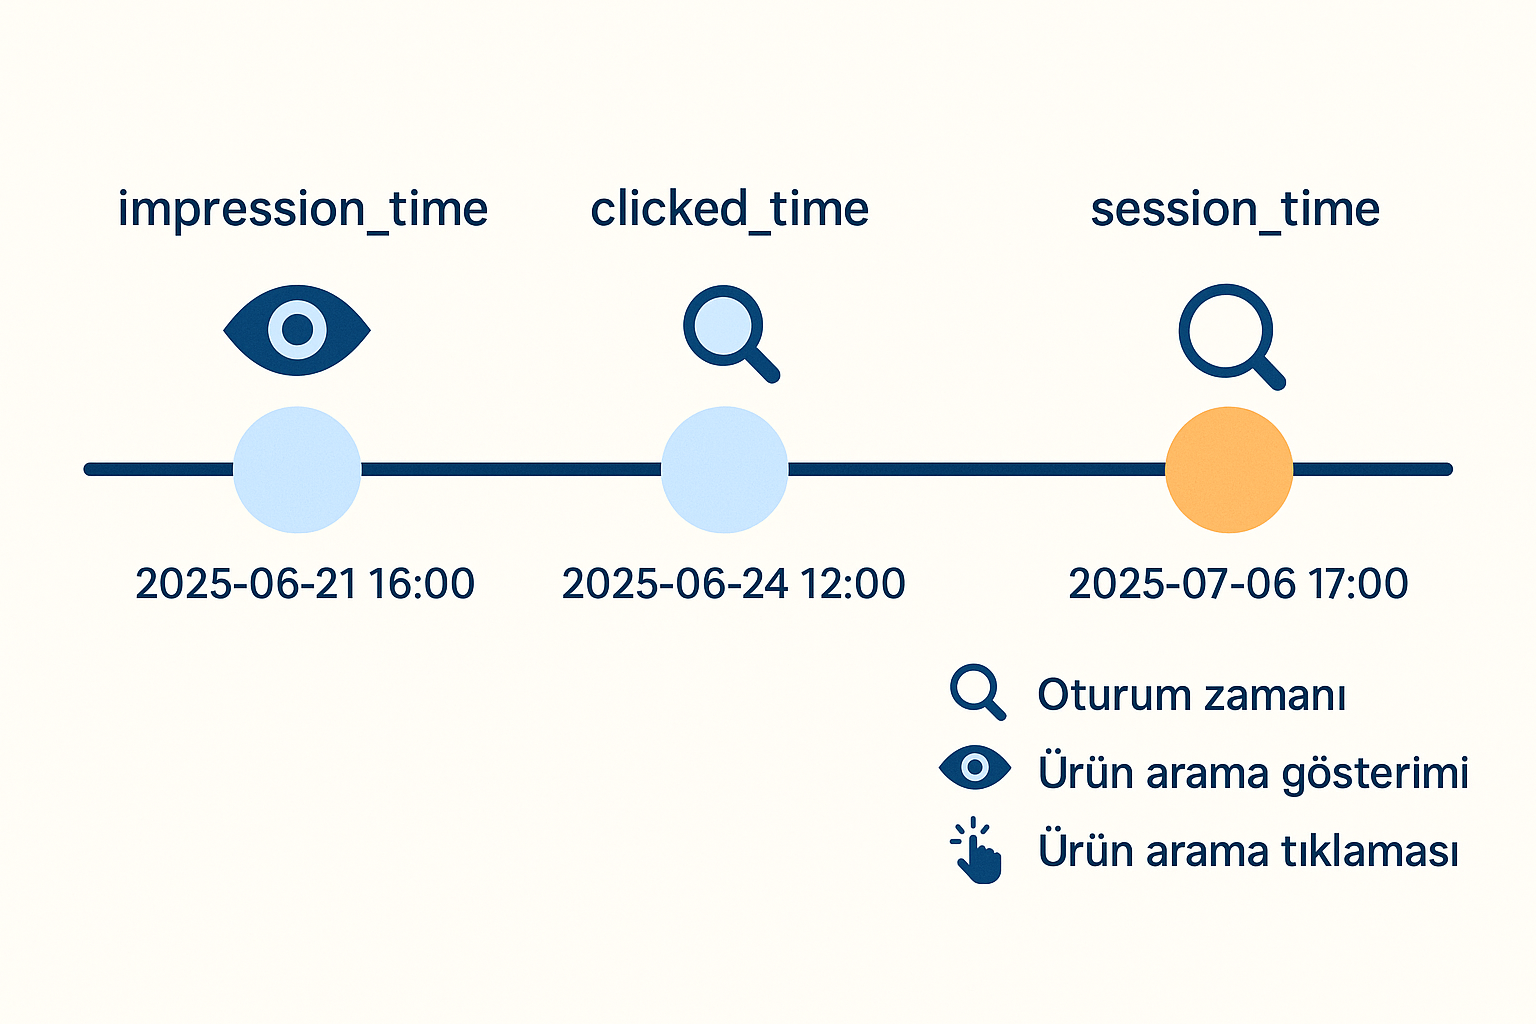

Böylece ilgili session_id zamanından önce o müşterinin o ürünü kaç kez tıkladığı ya da görüntülediği gibi bilgilere sahibiz.

Aşağıdaki örnekte **2025-07-06 17:00** tarihinde arama yapan kullanıcı aradığı ürünleri **2025-06-24 12:00** tarihinde tıkladığı görülmekte. 
Bu bilgiler bize modelin tahmin gücünü arttırmak için önemli ipuçları verecektir.

Train ve Test datamız içerisinde Toplamda **38392** unique user_id varken bunlardan sadece **684** tanesinin user_search_log tablsounda kaydı yok. **0.017**'lik bir kaybımız var fakat önemli değil.

## 3. Feature Engineering

### 3.1. Content/Term Dataset Rolling Feature

Bu bölümde elimizdeki content_id bilgilerine göre bu content_id'lerin geçmişte ne kadar görüntülendiğini ve tıklandığını hesaplayan fonksiyonlar yazacağız. 

**apply_rolling_windows_lazy_ic** total_search_impression ve total_search_click kolonlarını sayan fonksiyon.

**apply_rolling_windows_lazy_ccfo** total_click, total_fav, total_cart ve total_order kolonlarını sayan fonksiyon.

In [9]:
def apply_rolling_windows_lazy_ic(
    lf: pl.LazyFrame,
    periods: list[str],
    alias: str,
    *,
    index_col: str,
    by: Union[str, Iterable[str]],
    closed: str = "both",
) -> pl.LazyFrame:
    # 0) by -> liste olarak normalize et
    by_cols = [by] if isinstance(by, str) else list(by)

    # 1) tip ve sıralama garantisi (rolling önşartı: index_col gruplar içinde artan)
    base = (
        lf.with_columns(pl.col(index_col).cast(pl.Datetime))
          .sort(by_cols + [index_col])
    )

    # 2) her periyot için rolling agg
    roll = None
    for p in periods:
        agg = (
            base.rolling(
                index_column=index_col,
                period=p,
                group_by=by_cols,   # çoklu grup OK
                closed=closed,
            )
            .agg([
                pl.col("total_search_impression").sum().alias(f"{alias}_tsi_sum_{p}"),
                pl.col("total_search_impression").max().alias(f"{alias}_tsi_max_{p}"),
                pl.col("total_search_click").sum().alias(f"{alias}_tsc_sum_{p}"),
                pl.col("total_search_click").max().alias(f"{alias}_tsc_max_{p}"),
            ])
        )
        roll = agg if roll is None else roll.join(
            agg, on=by_cols + [index_col], how="full", coalesce=True
        )

    # 3) orijinale yapıştır
    out = base.join(roll, on=by_cols + [index_col], how="left", coalesce=True)
    return out

In [10]:
# --- content_search_log ---
content_search_log = apply_rolling_windows_lazy_ic(
    content_search_log,
    periods=["1d", "7d", "15d", "30d"], # Son 1, 7, 15 ve 30 gün verileri.
    alias="content_search_log",
    index_col="date",
    by="content_id_hashed"
)

# --- content_top_terms_log ---
content_top_terms_log = apply_rolling_windows_lazy_ic(
    content_top_terms_log,
    periods=["1d", "7d", "15d", "30d"],
    alias="content_top_terms_log",
    index_col="date",
    by=["search_term_normalized", "content_id_hashed"]
)

# --- term_search_log (Günlük) ---
term_search_log = apply_rolling_windows_lazy_ic(
    term_search_log,
    periods=["7d", "15d", "30d"],
    alias="term_search_log",
    index_col="ts_hour",
    by=["search_term_normalized"]
)

# --- term_search_log (Saatlik) ---
term_search_log = apply_rolling_windows_lazy_ic(
    term_search_log,
    periods=["3h", "12h", "24h"],
    alias="term_search_log",
    index_col="ts_hour",
    by=["search_term_normalized"]
)


In [11]:
def apply_rolling_windows_lazy_ccfo(
    lf: pl.LazyFrame,
    periods: list[str],
    alias: str,
    *,
    index_col: str,
    by: str,
    closed: str = "both",
) -> pl.LazyFrame:

    # 1) tip ve sıralama garantisi (rolling önşartları)
    base = (
        lf.with_columns(pl.col(index_col).cast(pl.Datetime))
          .sort([by, index_col])  # gruplar içinde tarih artan
    )

    # 2) her periyot için rolling agg
    roll = None
    for p in periods:
        agg = (
            base.rolling(
                index_column=index_col,
                period=p,
                group_by=by,
                closed=closed,
            )
            .agg([
                pl.col("total_click").sum().alias(f"{alias}_total_click_sum_{p}"),
                pl.col("total_click").max().alias(f"{alias}_total_click_max_{p}"),
                pl.col("total_cart").sum().alias(f"{alias}_total_cart_sum_{p}"),
                pl.col("total_cart").max().alias(f"{alias}_total_cart_max_{p}"),
                pl.col("total_fav").sum().alias(f"{alias}_total_fav_sum_{p}"),
                pl.col("total_fav").max().alias(f"{alias}_total_fav_max_{p}"),
                pl.col("total_order").sum().alias(f"{alias}_total_order_sum_{p}"),
                pl.col("total_order").max().alias(f"{alias}_total_order_max_{p}")
                ])
        )
        # çoklu periyodu tek tabloda birleştir
        roll = agg if roll is None else roll.join(
            agg, on=[by, index_col], how="full", coalesce=True
        )

    # 3) orijinal veriye geri yapıştır
    out = base.join(roll, on=[by, index_col], how="left", coalesce=True)
    return out


In [12]:
content_sitewide_log = apply_rolling_windows_lazy_ccfo(
    content_sitewide_log,
    periods=["1d", "7d", "15d", "30d"],
    alias="content_sitewide_log",
    index_col="date",
    by="content_id_hashed"
)

### 3.2. Content/Term Dataset Ek Feature

3.1.Bölümde oluşturduğumuz verileri kullanarak yeni feature'lar üreteceğiz.
Literatür araştırması sonrasında aşağıdaki rasyoların sonuca etki edeceğini düşünüyoruz.


* **CTR (Click-Through Rate)**
* **Trend Ratio**
* **Volatilite / Spikiness**
* **Growth Rate**

In [13]:
# --- content_search_log (CTR Features) ---
content_search_log = content_search_log.with_columns([
    (pl.col("content_search_log_tsc_sum_1d") / (pl.col("content_search_log_tsi_sum_1d") + 1e-8))
        .alias("content_search_log_ctr_1d"),
    (pl.col("content_search_log_tsc_sum_7d") / (pl.col("content_search_log_tsi_sum_7d") + 1e-8))
        .alias("content_search_log_ctr_7d"),
    (pl.col("content_search_log_tsc_sum_15d") / (pl.col("content_search_log_tsi_sum_15d") + 1e-8))
        .alias("content_search_log_ctr_15d"),
    (pl.col("content_search_log_tsc_sum_30d") / (pl.col("content_search_log_tsi_sum_30d") + 1e-8))
        .alias("content_search_log_ctr_30d"),
])

# --- content_search_log (Trend Ratio Features) ---
content_search_log = content_search_log.with_columns([
    (pl.col("content_search_log_tsc_sum_1d") / (pl.col("content_search_log_tsc_sum_7d") + 1e-8))
        .alias("content_search_log_tsc_trend_ratio_1_7d"),
    (pl.col("content_search_log_tsc_sum_7d") / (pl.col("content_search_log_tsc_sum_15d") + 1e-8))
        .alias("content_search_log_tsc_trend_ratio_7_15d"),
    (pl.col("content_search_log_tsi_sum_1d") / (pl.col("content_search_log_tsi_sum_7d") + 1e-8))
        .alias("content_search_log_tsi_trend_ratio_1_7d"),
    (pl.col("content_search_log_tsi_sum_7d") / (pl.col("content_search_log_tsi_sum_15d") + 1e-8))
        .alias("content_search_log_tsi_trend_ratio_7_15d"),
])

# --- content_search_log (Volatilite/Spikiness Features) ---
content_search_log = content_search_log.with_columns([
    (pl.col("content_search_log_tsc_max_7d") / (pl.col("content_search_log_tsc_sum_7d") + 1e-8))
        .alias("content_search_log_tsc_volatilite_7d"),
    (pl.col("content_search_log_tsc_max_15d") / (pl.col("content_search_log_tsc_sum_15d") + 1e-8))
        .alias("content_search_log_tsc_volatilite_15d"),
    (pl.col("content_search_log_tsi_max_7d") / (pl.col("content_search_log_tsi_sum_7d") + 1e-8))
        .alias("content_search_log_tsi_volatilite_7d"),
    (pl.col("content_search_log_tsi_max_15d") / (pl.col("content_search_log_tsi_sum_15d") + 1e-8))
        .alias("content_search_log_tsi_volatilite_15d"),
])

# --- content_search_log (Growth Rate Features) ---
content_search_log = content_search_log.with_columns([
    ((pl.col("content_search_log_tsc_sum_1d") - pl.col("content_search_log_tsc_sum_7d")) / 
     (pl.col("content_search_log_tsc_sum_7d") - pl.col("content_search_log_tsc_sum_15d") + 1e-8))
    .alias("content_search_log_tsc_growth_rate_1_7_15d"),

    ((pl.col("content_search_log_tsc_sum_7d") - pl.col("content_search_log_tsc_sum_15d")) / 
     (pl.col("content_search_log_tsc_sum_15d") - pl.col("content_search_log_tsc_sum_30d") + 1e-8))
    .alias("content_search_log_tsc_growth_rate_7_15_30d"),

    ((pl.col("content_search_log_tsi_sum_1d") - pl.col("content_search_log_tsi_sum_7d")) / 
     (pl.col("content_search_log_tsi_sum_7d") - pl.col("content_search_log_tsi_sum_15d") + 1e-8))
    .alias("content_search_log_tsi_growth_rate_1_7_15d"),

    ((pl.col("content_search_log_tsi_sum_7d") - pl.col("content_search_log_tsi_sum_15d")) / 
     (pl.col("content_search_log_tsi_sum_15d") - pl.col("content_search_log_tsi_sum_30d") + 1e-8))
    .alias("content_search_log_tsi_growth_rate_7_15_30d"),
])

content_search_log = (
    content_search_log
    .with_columns(pl.col("date").cast(pl.Date).alias("ts_date_1")) # ana tablomuzda hazırladığımız kolonla aynı isimde olması için
    .drop("date")  
)

In [14]:
# --- content_sitewide_log (CTR Features) ---
content_sitewide_log = content_sitewide_log.with_columns([
    (pl.col("content_sitewide_log_total_fav_sum_1d") / (pl.col("content_sitewide_log_total_click_sum_1d") + 1e-8))
        .alias("content_sitewide_log_ctr_fav_click_1d"),
    (pl.col("content_sitewide_log_total_fav_sum_7d") / (pl.col("content_sitewide_log_total_click_sum_7d") + 1e-8))
        .alias("content_sitewide_log_ctr_fav_click_7d"),
    (pl.col("content_sitewide_log_total_fav_sum_15d") / (pl.col("content_sitewide_log_total_click_sum_15d") + 1e-8))
        .alias("content_sitewide_log_ctr_fav_click_15d"),
    (pl.col("content_sitewide_log_total_cart_sum_1d") / (pl.col("content_sitewide_log_total_click_sum_1d") + 1e-8))
        .alias("content_sitewide_log_ctr_cart_click_1d"),
    (pl.col("content_sitewide_log_total_cart_sum_7d") / (pl.col("content_sitewide_log_total_click_sum_7d") + 1e-8))
        .alias("content_sitewide_log_ctr_cart_click_7d"),
    (pl.col("content_sitewide_log_total_cart_sum_15d") / (pl.col("content_sitewide_log_total_click_sum_15d") + 1e-8))
        .alias("content_sitewide_log_ctr_cart_click_15d"),
    (pl.col("content_sitewide_log_total_order_sum_1d") / (pl.col("content_sitewide_log_total_click_sum_1d") + 1e-8))
        .alias("content_sitewide_log_ctr_order_click_1d"),
    (pl.col("content_sitewide_log_total_order_sum_7d") / (pl.col("content_sitewide_log_total_click_sum_7d") + 1e-8))
        .alias("content_sitewide_log_ctr_order_click_7d"),
    (pl.col("content_sitewide_log_total_order_sum_15d") / (pl.col("content_sitewide_log_total_click_sum_15d") + 1e-8))
        .alias("content_sitewide_log_ctr_order_click_15d"),
])

# --- content_sitewide_log (Trend Ratio Features) ---
content_sitewide_log = content_sitewide_log.with_columns([
    (pl.col("content_sitewide_log_total_order_sum_1d") / (pl.col("content_sitewide_log_total_order_sum_7d") + 1e-8))
        .alias("content_sitewide_log_total_order_trend_ratio_1d"),
    (pl.col("content_sitewide_log_total_order_sum_7d") / (pl.col("content_sitewide_log_total_order_sum_15d") + 1e-8))
        .alias("content_sitewide_log_total_order_trend_ratio_7_15d"),
    (pl.col("content_sitewide_log_total_fav_sum_1d") / (pl.col("content_sitewide_log_total_fav_sum_7d") + 1e-8))
        .alias("content_sitewide_log_total_fav_trend_ratio_1d"),
    (pl.col("content_sitewide_log_total_fav_sum_7d") / (pl.col("content_sitewide_log_total_fav_sum_15d") + 1e-8))
        .alias("content_sitewide_log_total_fav_trend_ratio_7_15d"),
    (pl.col("content_sitewide_log_total_cart_sum_1d") / (pl.col("content_sitewide_log_total_cart_sum_7d") + 1e-8))
        .alias("content_sitewide_log_total_cart_trend_ratio_1d"),
    (pl.col("content_sitewide_log_total_cart_sum_7d") / (pl.col("content_sitewide_log_total_cart_sum_15d") + 1e-8))
        .alias("content_sitewide_log_total_cart_trend_ratio_7_15d"),
])

# --- content_sitewide_log (Volatilite/Spikiness Features) ---
content_sitewide_log = content_sitewide_log.with_columns([
    (pl.col("content_sitewide_log_total_order_max_7d") / (pl.col("content_sitewide_log_total_order_sum_7d") + 1e-8))
        .alias("content_sitewide_log_total_order_volatile_7d"),
    (pl.col("content_sitewide_log_total_fav_max_15d") / (pl.col("content_sitewide_log_total_fav_sum_15d") + 1e-8))
        .alias("content_sitewide_log_total_fav_volatile_7d"),
    (pl.col("content_sitewide_log_total_cart_max_15d") / (pl.col("content_sitewide_log_total_cart_sum_15d") + 1e-8))
        .alias("content_sitewide_log_total_cart_volatile_7d"),
])

# --- content_sitewide_log (Growth Rate Features) ---
content_sitewide_log = content_sitewide_log.with_columns([
    ((pl.col("content_sitewide_log_total_fav_sum_1d") - pl.col("content_sitewide_log_total_fav_sum_7d")) / 
     (pl.col("content_sitewide_log_total_fav_sum_7d") - pl.col("content_sitewide_log_total_fav_sum_15d") + 1e-8))
    .alias("content_sitewide_log_total_fav_growth_rate_1_7_15d"),
    ((pl.col("content_sitewide_log_total_fav_sum_7d") - pl.col("content_sitewide_log_total_fav_sum_15d")) / 
     (pl.col("content_sitewide_log_total_fav_sum_15d") - pl.col("content_sitewide_log_total_fav_sum_30d") + 1e-8))
    .alias("content_sitewide_log_total_fav_growth_rate_7_15_30d"),
    ((pl.col("content_sitewide_log_total_order_sum_1d") - pl.col("content_sitewide_log_total_order_sum_7d")) / 
     (pl.col("content_sitewide_log_total_order_sum_7d") - pl.col("content_sitewide_log_total_order_sum_15d") + 1e-8))
    .alias("content_sitewide_log_total_order_growth_rate_1_7_15d"),
    ((pl.col("content_sitewide_log_total_order_sum_7d") - pl.col("content_sitewide_log_total_order_sum_15d")) / 
     (pl.col("content_sitewide_log_total_order_sum_15d") - pl.col("content_sitewide_log_total_order_sum_30d") + 1e-8))
    .alias("content_sitewide_log_total_order_growth_rate_7_15_30d"),
    ((pl.col("content_sitewide_log_total_click_sum_1d") - pl.col("content_sitewide_log_total_click_sum_7d")) / 
     (pl.col("content_sitewide_log_total_click_sum_7d") - pl.col("content_sitewide_log_total_click_sum_15d") + 1e-8))
    .alias("content_sitewide_log_total_click_growth_rate_1_7_15d"),
    ((pl.col("content_sitewide_log_total_click_sum_7d") - pl.col("content_sitewide_log_total_click_sum_15d")) / 
     (pl.col("content_sitewide_log_total_click_sum_15d") - pl.col("content_sitewide_log_total_click_sum_30d") + 1e-8))
    .alias("content_sitewide_log_total_click_growth_rate_7_15_30d"),

])

content_sitewide_log = (
    content_sitewide_log
    .with_columns(pl.col("date").cast(pl.Date).alias("ts_date_1")) # ana tablomuzda hazırladığımız kolonla aynı isimde olması için
    .drop("date") 
)


In [15]:
# --- content_top_terms_log (CTR Features) ---
content_top_terms_log = content_top_terms_log.with_columns([
    (pl.col("content_top_terms_log_tsc_sum_1d") / (pl.col("content_top_terms_log_tsi_sum_1d") + 1e-8))
        .alias("content_top_terms_log_ctr_1d"),
    (pl.col("content_top_terms_log_tsc_sum_7d") / (pl.col("content_top_terms_log_tsi_sum_7d") + 1e-8))
        .alias("content_top_terms_log_ctr_7d"),
    (pl.col("content_top_terms_log_tsc_sum_15d") / (pl.col("content_top_terms_log_tsi_sum_15d") + 1e-8))
        .alias("content_top_terms_log_ctr_15d"),
    (pl.col("content_top_terms_log_tsc_sum_30d") / (pl.col("content_top_terms_log_tsi_sum_30d") + 1e-8))
        .alias("content_top_terms_log_ctr_30d"),
])

# --- content_top_terms_log (Trend Ratio Features) ---
content_top_terms_log = content_top_terms_log.with_columns([
    (pl.col("content_top_terms_log_tsc_sum_1d") / (pl.col("content_top_terms_log_tsc_sum_7d") + 1e-8))
        .alias("content_top_terms_log_tsc_trend_ratio_1_7d"),
    (pl.col("content_top_terms_log_tsc_sum_7d") / (pl.col("content_top_terms_log_tsc_sum_15d") + 1e-8))
        .alias("content_top_terms_log_tsc_trend_ratio_7_15d"),
    (pl.col("content_top_terms_log_tsi_sum_1d") / (pl.col("content_top_terms_log_tsi_sum_7d") + 1e-8))
        .alias("content_top_terms_log_tsi_trend_ratio_1_7d"),
    (pl.col("content_top_terms_log_tsi_sum_7d") / (pl.col("content_top_terms_log_tsi_sum_15d") + 1e-8))
        .alias("content_top_terms_log_tsi_trend_ratio_7_15d"),
])

# --- content_top_terms_log (Volatilite/Spikiness Features) ---
content_top_terms_log = content_top_terms_log.with_columns([
    (pl.col("content_top_terms_log_tsc_max_7d") / (pl.col("content_top_terms_log_tsc_sum_7d") + 1e-8))
        .alias("content_top_terms_log_tsc_volatilite_7d"),
    (pl.col("content_top_terms_log_tsc_max_15d") / (pl.col("content_top_terms_log_tsc_sum_15d") + 1e-8))
        .alias("content_top_terms_log_tsc_volatilite_15d"),
    (pl.col("content_top_terms_log_tsi_max_7d") / (pl.col("content_top_terms_log_tsi_sum_7d") + 1e-8))
        .alias("content_top_terms_log_tsi_volatilite_7d"),
    (pl.col("content_top_terms_log_tsi_max_15d") / (pl.col("content_top_terms_log_tsi_sum_15d") + 1e-8))
        .alias("content_top_terms_log_tsi_volatilite_15d"),
])

# --- content_top_terms_log (Growth Rate Features) ---
content_top_terms_log = content_top_terms_log.with_columns([
    ((pl.col("content_top_terms_log_tsc_sum_1d") - pl.col("content_top_terms_log_tsc_sum_7d")) / 
     (pl.col("content_top_terms_log_tsc_sum_7d") - pl.col("content_top_terms_log_tsc_sum_15d") + 1e-8))
    .alias("content_top_terms_log_tsc_growth_rate_1_7_15d"),

    ((pl.col("content_top_terms_log_tsc_sum_7d") - pl.col("content_top_terms_log_tsc_sum_15d")) / 
     (pl.col("content_top_terms_log_tsc_sum_15d") - pl.col("content_top_terms_log_tsc_sum_30d") + 1e-8))
    .alias("content_top_terms_log_tsc_growth_rate_7_15_30d"),

    ((pl.col("content_top_terms_log_tsi_sum_1d") - pl.col("content_top_terms_log_tsi_sum_7d")) / 
     (pl.col("content_top_terms_log_tsi_sum_7d") - pl.col("content_top_terms_log_tsi_sum_15d") + 1e-8))
    .alias("content_top_terms_log_tsi_growth_rate_1_7_15d"),

    ((pl.col("content_top_terms_log_tsi_sum_7d") - pl.col("content_top_terms_log_tsi_sum_15d")) / 
     (pl.col("content_top_terms_log_tsi_sum_15d") - pl.col("content_top_terms_log_tsi_sum_30d") + 1e-8))
    .alias("content_top_terms_log_tsi_growth_rate_7_15_30d"),
])

content_top_terms_log = (
    content_top_terms_log
    .with_columns(pl.col("date").cast(pl.Date).alias("ts_date_1")) # ana tablomuzda hazırladığımız kolonla aynı isimde olması için
    .drop("date")  
)

In [16]:
# --- term_search_log (Trend Ratio Features) ---
term_search_log = term_search_log.with_columns([
    (pl.col("term_search_log_tsc_sum_24h") / (pl.col("term_search_log_tsc_sum_7d") + 1e-8))
        .alias("term_search_log_tsc_trend_ratio_1_7d"),
    (pl.col("term_search_log_tsc_sum_7d") / (pl.col("term_search_log_tsc_sum_15d") + 1e-8))
        .alias("term_search_log_tsc_trend_ratio_7_15d"),
    (pl.col("term_search_log_tsi_sum_24h") / (pl.col("term_search_log_tsi_sum_7d") + 1e-8))
        .alias("term_search_log_tsi_trend_ratio_1_7d"),
    (pl.col("term_search_log_tsi_sum_7d") / (pl.col("term_search_log_tsi_sum_15d") + 1e-8))
        .alias("term_search_log_tsi_trend_ratio_7_15d"),
])

# --- term_search_log (Growth Rate Features) ---
term_search_log = term_search_log.with_columns([
    ((pl.col("term_search_log_tsc_sum_24h") - pl.col("term_search_log_tsc_sum_7d")) / 
     (pl.col("term_search_log_tsc_sum_7d") - pl.col("term_search_log_tsc_sum_15d") + 1e-8))
    .alias("term_search_log_tsc_growth_rate_1_7_15d"),

    ((pl.col("term_search_log_tsc_sum_7d") - pl.col("term_search_log_tsc_sum_15d")) / 
     (pl.col("term_search_log_tsc_sum_15d") - pl.col("term_search_log_tsc_sum_30d") + 1e-8))
    .alias("term_search_log_tsc_growth_rate_7_15_30d"),

    ((pl.col("term_search_log_tsi_sum_24h") - pl.col("term_search_log_tsi_sum_7d")) / 
     (pl.col("term_search_log_tsi_sum_7d") - pl.col("term_search_log_tsi_sum_15d") + 1e-8))
    .alias("term_search_log_tsi_growth_rate_1_7_15d"),

    ((pl.col("term_search_log_tsi_sum_7d") - pl.col("term_search_log_tsi_sum_15d")) / 
     (pl.col("term_search_log_tsi_sum_15d") - pl.col("term_search_log_tsi_sum_30d") + 1e-8))
    .alias("term_search_log_tsi_growth_rate_7_15_30d"),
])

term_search_log = term_search_log.rename({"ts_hour": "ts_date_25h"})##.with_columns(pl.col("ts_date_25h").dt.replace_time_zone("UTC"))


### 3.3. User Dataset Rolling Feature

Bu bölümde elimizdeki user_id bilgilerine göre bu userların ilgili ürünleri geçmişte ne kadar görüntülendiğini ve tıklandığını hesaplayan fonksiyonlar yazacağız. 

**add_log_window_sums_cumsum** total_search_impression ve total_search_click kolonlarını sayan fonksiyon.

**add_action_window_sums_cumsum** total_click, total_fav, total_cart ve total_order kolonlarını sayan fonksiyon.

In [17]:
def add_log_window_sums_cumsum(
    current_lf: pl.LazyFrame,
    log_lf: pl.LazyFrame,
    *,
    windows: Iterable[str] = ("1d","3d","7d","15d","30d"),
    prefix: str = "",
    current_ts: str = "ts_date_25h",
    log_ts: str = "ts_hour",
    user_col: str = "user_id_hashed",
    item_col: Optional[str] = None,  # <-- opsiyonel hale getirildi
    imp_col: str = "total_search_impression",
    clk_col: str = "total_search_click",
    tz: str = "UTC",
) -> pl.LazyFrame:
    """
    content_id yoksa item_col=None verin YA DA fonksiyon otomatik düşürür.
    Çıktı: {prefix}{imp_col}_sum_{p}, {prefix}{clk_col}_sum_{p} (p ∈ windows)
    """
    _pref = (prefix + "_") if prefix and not prefix.endswith("_") else prefix

    # --- item_col otomatik tespiti (yoksa user-level moda düş) ---
    try:
        cur_has = item_col in current_lf.schema if item_col else False
        log_has = item_col in log_lf.schema if item_col else False
    except Exception:
        cur_has = log_has = False
    if not item_col or not (cur_has and log_has):
        item_col = None  # yalnızca user_col ile gruplama

    by_cols = [user_col] + ([item_col] if item_col else [])

    # --- yardımcılar ---
    def _dur(p: str) -> pl.duration:
        m = re.fullmatch(r"(\d+)([hd])", p)
        if not m:
            raise ValueError(f"Unsupported window format: {p} (use 'Nd' or 'Nh')")
        n, u = int(m.group(1)), m.group(2)
        return pl.duration(days=n) if u == "d" else pl.duration(hours=n)

    def _asof_kwargs(left_key: str, right_key: str) -> dict:
        kw = dict(left_on=left_key, right_on=right_key, strategy="backward")
        if by_cols:
            kw["by"] = by_cols
        return kw

    # --- current tarafı: TZ set + sırala (asof gereği) ---
    cur = (
        current_lf.with_columns(
            pl.col(current_ts).cast(pl.Datetime).dt.replace_time_zone(tz).alias("_ts_cur")
        )
        .sort(by_cols + ["_ts_cur"])
    )

    # --- log tarafı: ÖNCE sırala, SONRA kümülatif (sıralamaya duyarlı) ---
    log_sorted = (
        log_lf.with_columns(
            pl.col(log_ts).cast(pl.Datetime).dt.replace_time_zone(tz).alias("_ts_log")
        )
        .sort(by_cols + ["_ts_log"])
    )

    cum = (
        log_sorted.with_columns([
            pl.col(imp_col).fill_null(0.0).cum_sum().over(by_cols).alias("_cum_imp"),
            pl.col(clk_col).fill_null(0.0).cum_sum().over(by_cols).alias("_cum_clk"),
        ])
        .select((by_cols if by_cols else []) + ["_ts_log", "_cum_imp", "_cum_clk"])
    )
    # Not: cum_sum sıralamaya duyarlıdır; önce sıralayıp sonra kümülatif almak gerekir. :contentReference[oaicite:2]{index=2}

    # --- current anındaki kümülatifler (sağ <= sol) ---
    out = (
        cur.join_asof(cum, **_asof_kwargs("_ts_cur", "_ts_log"))
           .with_columns([
               pl.col("_cum_imp").fill_null(0.0).alias("_cum_imp_cur"),
               pl.col("_cum_clk").fill_null(0.0).alias("_cum_clk_cur"),
           ])
           .drop(["_ts_log", "_cum_imp", "_cum_clk"], strict=False)
    )

    # --- her pencere için: (t - p) anındaki baz kümülatifleri çek → fark al ---
    for p in windows:
        start_col = f"_ts_start_{p}"
        out = out.with_columns((pl.col("_ts_cur") - _dur(p)).alias(start_col))

        out = (
            out.sort(by_cols + [start_col])
               .join_asof(cum, **_asof_kwargs(start_col, "_ts_log"))
               .with_columns([
                   pl.col("_cum_imp").fill_null(0.0).alias(f"_cum_imp_base_{p}"),
                   pl.col("_cum_clk").fill_null(0.0).alias(f"_cum_clk_base_{p}"),
               ])
               .drop(["_ts_log", "_cum_imp", "_cum_clk"], strict=False)
        )

        out = out.with_columns([
            (pl.col("_cum_imp_cur") - pl.col(f"_cum_imp_base_{p}")).alias(f"{_pref}{imp_col}_sum_{p}"),
            (pl.col("_cum_clk_cur") - pl.col(f"_cum_clk_base_{p}")).alias(f"{_pref}{clk_col}_sum_{p}"),
        ])

    # --- temizlik ---
    to_drop = (
        ["_ts_cur"]
        + [f"_ts_start_{p}" for p in windows]
        + ["_cum_imp_cur","_cum_clk_cur"]
        + [f"_cum_imp_base_{p}" for p in windows]
        + [f"_cum_clk_base_{p}" for p in windows]
    )
    return out.drop(to_drop, strict=False)


In [18]:
current_data = (
    df_all
    .select(["ts_date_25h", "user_id_hashed", "content_id_hashed", "session_id"]))

user_fashion_search_log = add_log_window_sums_cumsum(
    current_lf=current_data,
    log_lf=user_fashion_search_log,
    item_col="content_id_hashed",
    windows=("6h", "12h", "1d", "3d", "7d", "30d"),
    prefix="user_fashion_search_log",)

current_data = (
    df_all
    .select(["ts_date_25h", "user_id_hashed", "search_term_normalized", "content_id_hashed", "session_id"]))

user_top_terms_log = add_log_window_sums_cumsum(
    current_lf=current_data,
    log_lf=user_top_terms_log,
    item_col = "search_term_normalized",
    windows=("6h", "12h", "1d", "3d", "7d", "30d"),
    prefix="user_top_terms_log",)

current_data = (
    df_all
    .select(["ts_date_25h", "user_id_hashed", "content_id_hashed", "session_id"]))

user_search_log = add_log_window_sums_cumsum(
    current_lf=current_data,
    log_lf=user_search_log,
    windows=("6h", "12h", "1d", "3d", "7d", "30d"),
    prefix="user_search_log",)

In [19]:
def add_action_window_sums_cumsum(
    current_lf: pl.LazyFrame,
    log_lf: pl.LazyFrame,
    *,
    windows: Iterable[str] = ("1d", "3d", "7d", "15d", "30d"),
    prefix: str = "",
    current_ts: str = "ts_hour",
    log_ts: str = "ts_hour",
    user_col: str = "user_id_hashed",
    item_col: Optional[str] = None,    # None => sadece kullanıcı bazlı
    metrics: Sequence[str] = ("total_click", "total_cart", "total_fav", "total_order"),
    tz: str = "UTC",
    ensure_non_negative: bool = True,
) -> pl.LazyFrame:
    _pref = (prefix + "_") if prefix and not prefix.endswith("_") else prefix
    by_cols = [user_col] + ([item_col] if item_col else [])

    def _dur(p: str) -> pl.duration:
        m = re.fullmatch(r"(\d+)([hd])", p)
        if not m:
            raise ValueError(f"Desteklenmeyen pencere formatı: {p} (örn. '7d' veya '12h')")
        n, u = int(m.group(1)), m.group(2)
        return pl.duration(days=n) if u == "d" else pl.duration(hours=n)

    def _by_kwargs(left_key: str, right_key: str) -> dict:
        kw = dict(left_on=left_key, right_on=right_key, strategy="backward")
        if by_cols:
            kw["by"] = by_cols
        return kw

    # current: TZ ekle + sırala (asof için zorunlu)
    cur = (
        current_lf.with_columns(
            pl.col(current_ts).cast(pl.Datetime).dt.replace_time_zone(tz).alias("_ts_cur")
        )
        .sort(by_cols + ["_ts_cur"])
    )

    # log: ÖNCE sırala, SONRA kümülatif (negatif farkları önler)
    log_sorted = (
        log_lf.with_columns(
            pl.col(log_ts).cast(pl.Datetime).dt.replace_time_zone(tz).alias("_ts_log")
        )
        .sort(by_cols + ["_ts_log"])
    )

    cum_cols = [f"_cum_{m}" for m in metrics]
    cum = (
        log_sorted.with_columns([
            pl.col(m).fill_null(0).cum_sum().over(by_cols).alias(f"_cum_{m}")
            for m in metrics
        ])
        .select((by_cols if by_cols else []) + ["_ts_log"] + cum_cols)
    )

    # current anındaki kümülatifler
    out = (
        cur.join_asof(cum, **_by_kwargs("_ts_cur", "_ts_log"))
           .with_columns([pl.col(c).fill_null(0).alias(f"_cur{c}") for c in cum_cols])
           .drop(["_ts_log"] + cum_cols, strict=False)
    )

    # pencere bazlı farklar
    for p in windows:
        start_col = f"_ts_start_{p}"
        out = out.with_columns((pl.col("_ts_cur") - _dur(p)).alias(start_col))
        out = (
            out.sort(by_cols + [start_col])
               .join_asof(cum, **_by_kwargs(start_col, "_ts_log"))
        )

        diffs = []
        for m in metrics:
            cur_c = f"_cur_cum_{m}"
            base_c = f"_cum_{m}"
            expr = pl.col(cur_c) - pl.col(base_c).fill_null(0)
            if ensure_non_negative:
                # clip_min yerine, sürümden bağımsız güvenli yöntem:
                expr = pl.when(expr < 0).then(pl.lit(0)).otherwise(expr)
            diffs.append(expr.alias(f"{_pref}{m}_sum_{p}"))

        out = out.with_columns(diffs).drop(["_ts_log"] + cum_cols, strict=False)

    to_drop = ["_ts_cur"] + [f"_ts_start_{p}" for p in windows] + [f"_cur_cum_{m}" for m in metrics]
    return out.drop(to_drop, strict=False)


In [20]:
current_data = (
    df_all
    .select(["ts_date_25h", "user_id_hashed", "content_id_hashed", "session_id"]))

user_fashion_sitewide_log = add_action_window_sums_cumsum(
    current_lf=current_data,
    log_lf=user_fashion_sitewide_log,
    windows=("6h","12h","1d","7d","30d"),
    prefix="user_fashion_sitewide_log",
    current_ts="ts_date_25h",
    log_ts="ts_hour",
    user_col="user_id_hashed",
    item_col="content_id_hashed",
    metrics=("total_click","total_cart","total_fav","total_order"),
    tz="UTC",)

current_data = (
    df_all
    .select(["ts_date_25h", "user_id_hashed", "content_id_hashed", "session_id"])    
)

user_sitewide_log = add_action_window_sums_cumsum(
    current_lf=current_data,
    log_lf=user_sitewide_log,
    windows=("6h","12h","1d","7d","30d"),
    prefix="user_sitewide_log",
    current_ts="ts_date_25h",
    log_ts="ts_hour",
    user_col="user_id_hashed",
    #item_col="content_id_hashed",
    metrics=("total_click","total_cart","total_fav","total_order"),
    tz="UTC",
)

### 3.4. Tüm Datasetlerin Birleştirilmesi

Ürettiğimiz tüm feature'ların main datamız ile birleştireceğiz. 
Ek olarak fiyat, indirim, kategori bazında göreceli fiyatların hesaplanacak bir fonksiyon daha olacak.

In [21]:
df_all_v2 = df_all.join(   # --- df_all main datamız ---
    content_metadata,
    on="content_id_hashed",
    how="left")


df_all_v2 = df_all_v2.with_columns(
    pl.col("ts_date_1").sub(
        pl.col("content_creation_date")
    ).dt.total_days().alias("content_creation_date"))  # --- günümüzden content_creation_date kolonunu çıkararak ürün yaşı hesapladık.


df_all_v2 = df_all_v2.with_columns(
    pl.col("cv_tags").str.split(by=",").list.len().alias("cv_tags"))  # --- ilgili ürün için unique tags saydırdık


df_all_v3 = df_all_v2.join(
    content_price_data,
    on=["content_id_hashed", "ts_date"],
    how="left")


df_all_v4 = df_all_v3.join(
    content_search_log,
    on=["content_id_hashed", "ts_date_1"],
    how="left")


df_all_v5 = df_all_v4.join(
    content_sitewide_log,
    on=["content_id_hashed", "ts_date_1"],
    how="left")


df_all_v6 = df_all_v5.join(
    content_top_terms_log,
    on=["search_term_normalized", "content_id_hashed", "ts_date_1"],
    how="left")


df_all_v7 = df_all_v6.join(
    term_search_log,
    on=["search_term_normalized", "ts_date_25h"],
    how="left", suffix="_xyz")


df_all_v8 = df_all_v7.join(
    user_fashion_search_log,
    on=["ts_date_25h", "user_id_hashed", "content_id_hashed", "session_id"],
    how="left", suffix="cumsum")


df_all_v9 = df_all_v8.join(
    user_fashion_sitewide_log,
    on=["ts_date_25h", "user_id_hashed", "content_id_hashed", "session_id"],
    how="left",
    suffix="cumsum_sitewide",)


df_all_v10 = df_all_v9.join(
    user_metadata,
    on=["user_id_hashed"],
    how="left", suffix="_user_metadata")


df_all_v11 = df_all_v10.join(
    user_sitewide_log,
    on=["ts_date_25h", "user_id_hashed", "content_id_hashed", "session_id"],
    how="left", suffix="_user_sitewide_log")


df_all_v12 = df_all_v11.join(
    user_top_terms_log,
    on=["ts_date_25h", "user_id_hashed", "content_id_hashed",  "search_term_normalized", "session_id"],
    how="left", suffix="_user_top_terms_log")


df_all_v13 = df_all_v12.join(
    user_search_log, on=["ts_date_25h", "user_id_hashed", "content_id_hashed", "session_id"],
    how="left", suffix="_user_search_log")


In [22]:
def add_price_features(out: pl.DataFrame) -> pl.DataFrame:
    cols = set(out.columns)
    exprs = []

    # --- Güvenli kaynak expr'leri (kolon yoksa 0.0) ---
    orig = pl.col("original_price") if "original_price" in cols else pl.lit(0.0)
    disc = pl.col("discounted_price") if "discounted_price" in cols else pl.lit(0.0)

    # --- Temel fiyat türevleri ---
    exprs += [
        ((orig - disc) / (orig + pl.lit(1e-6))).cast(pl.Float32).alias("discount_rate"),
        # yeni (sürüm uyumlu)
        (orig + pl.lit(1)).log().cast(pl.Float32).alias("log_original_price"),
        (disc + pl.lit(1)).log().cast(pl.Float32).alias("log_discounted_price"),

    ]

    # --- Leaf kategori içi göreli fiyatlar ---
    if "leaf_category_name" in cols and "discounted_price" in cols:
        mean_leaf = pl.col("discounted_price").mean().over("leaf_category_name")
        std_leaf  = pl.col("discounted_price").std().over("leaf_category_name")
        safe_std  = pl.when(std_leaf == 0.0).then(None).otherwise(std_leaf)

        z_expr = (pl.col("discounted_price") - mean_leaf) / safe_std
        z_safe = pl.when(z_expr.is_finite()).then(z_expr).otherwise(0.0)

        exprs += [
            mean_leaf.cast(pl.Float32).alias("leaf_price_mean"),
            std_leaf.cast(pl.Float32).alias("leaf_price_std"),
            z_safe.cast(pl.Float32).alias("price_z_leaf"),
            (
                pl.col("discounted_price")
                .rank(method="ordinal")                # pandas rank(method='first') benzeri
                .over("leaf_category_name")
                / pl.count().over("leaf_category_name") # yüzdeleşme
            ).cast(pl.Float32).alias("price_rank_leaf"),
        ]

    return out.with_columns(exprs)

df_all_v14 = add_price_features(df_all_v13)

In [23]:
print(f"Toplam Feature Sayısı {len(df_all_v14.collect_schema())}")

# df_all_v14.collect_schema()  

# --- Bu kısımda collect_schema() ile şemanın sorunsuz çalıştığını görebiliriz.

Toplam Feature Sayısı 276


## 3. Veri Yükleme

Datanın oldukça büyük olmasından dolayı datayı **collect()** ile çalıştırmak kernel'in patlamasına sebep olacaktır. Bu sebeple datanın son halini yüklediğimiz .parquet dosyasından alabilirsiniz. 

In [24]:
if DATA_PREP:
    df_final_data = (df_all_v14
                     .collect()
                     .to_pandas())
else:
    df_final_data = pl.read_parquet(
        F"{DATA_PATH}/df_final_data.parquet", memory_map=True).to_pandas()

In [40]:
df_new = df_final_data[df_final_data["split"]=="train"]

DROP_COLS = ['ts_hour','user_id_hashed', 'content_id_hashed', 'session_id',
             'ts_date','ts_date_1', 'ts_date_25h', 'split',"ts_date_xyz"]

df_new = df_new.drop(columns=DROP_COLS, errors="ignore").reset_index(drop=True).fillna(-9999) 

## 4. Feature Selection

Bu aşamada Catboost ve Shap'ı kullanarak modele katkı sağlayabilecek en iyi değişkenleri seçtik. 
Bu aşama çok uzun sürdüğü için 

FEATURE_SELECTION = False

ayarı ile hızlıca geçebilirsiniz.

In [42]:
FEATURE_SELECTION = False

if FEATURE_SELECTION:
    summaries = []

    # Eğitim verisi
    X = df_new.drop(columns=["clicked", "ordered"]).copy()
    y = df_new["clicked"].copy()
    cat_idx = X.select_dtypes(include=["object", "category"]).columns.tolist()
    

    # StratifiedKFold tanımı
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for fold_id, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        # Kategorik sütunları işaretle
        for col in cat_idx:
            X_train[col] = X_train[col].fillna("nan").astype(str).astype("category")
            X_val[col] = X_val[col].fillna("nan").astype(str).astype("category")

        params = {
            'iterations': 3500,
            'learning_rate': 0.05,
            'depth': 5,
            'loss_function': 'Logloss',
            'eval_metric': 'AUC',
            'verbose': 200,
            'border_count': 254,
            'task_type': 'CPU',
            'auto_class_weights':"Balanced",
            'use_best_model': False,
            'cat_features': cat_idx,
        }

        model = CatBoostClassifier(**params)

        train_pool = Pool(X_train, y_train, cat_features=cat_idx)
        val_pool = Pool(X_val, y_val, cat_features=cat_idx)

        summary = model.select_features(
            train_pool,
            eval_set=val_pool,
            features_for_select='0-{}'.format(X_train.shape[1]-1),
            num_features_to_select=50,
            steps=5,
            algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
            shap_calc_type=EShapCalcType.Regular,
            train_final_model=False,
            logging_level='Silent',
            plot=True
        )

        summaries.append(summary)

    # Tüm fold'lardaki seçimlerin birleşimi (benzersiz)
    features_clicked = list(set(np.concatenate([summary["selected_features_names"] for summary in summaries])))

else:
    
    features_clicked = [
         'user_fashion_sitewide_log_total_cart_sum_30d','content_sitewide_log_total_cart_max_30d','level2_category_name',
         'price_z_leaf','content_sitewide_log_total_click_max_1d','content_sitewide_log_total_order_max_1d',
         'user_sitewide_log_total_click_sum_7d','term_search_log_tsc_trend_ratio_7_15d',
         'term_search_log_tsi_max_24h','content_search_log_tsi_sum_15d','content_sitewide_log_total_cart_volatile_7d',
         'content_sitewide_log_total_cart_max_1d','user_fashion_search_log_total_search_click_sum_30d',
         'user_search_log_total_search_click_sum_12h','total_order','content_top_terms_log_tsi_max_30d',
         'term_search_log_tsi_trend_ratio_7_15d','content_sitewide_log_ctr_order_click_1d','content_creation_date',
         'term_search_log_tsi_max_12h','term_search_log_tsc_growth_rate_1_7_15d','content_top_terms_log_tsc_volatilite_7d',
         'term_search_log_tsi_max_30d','content_top_terms_log_tsi_sum_30d','user_sitewide_log_total_fav_sum_7d',
         'leaf_price_std','content_top_terms_log_tsi_growth_rate_1_7_15d','merchant_count',
         'user_sitewide_log_total_fav_sum_30d','term_search_log_tsc_sum_12h','content_sitewide_log_ctr_fav_click_7d',
         'content_top_terms_log_tsc_volatilite_15d','content_search_log_tsc_trend_ratio_1_7d','total_click',
         'user_sitewide_log_total_click_sum_1d','content_sitewide_log_total_order_sum_7d',
         'content_search_log_tsi_growth_rate_7_15_30d','content_top_terms_log_tsc_sum_30d',
         'user_sitewide_log_total_order_sum_30d','term_search_log_tsc_sum_3h',
         'content_sitewide_log_total_fav_trend_ratio_1d','content_search_log_ctr_1d',
         'content_search_log_ctr_30d','content_top_terms_log_tsi_volatilite_7d',
         'user_search_log_total_search_impression_sum_7d','user_search_log_total_search_impression_sum_12h',
         'user_sitewide_log_total_click_sum_30d','content_sitewide_log_ctr_fav_click_1d','content_sitewide_log_total_cart_max_7d',
         'user_search_log_total_search_click_sum_30d','user_search_log_total_search_impression_sum_30d','content_search_log_tsi_volatilite_7d',
         'content_sitewide_log_ctr_order_click_15d','total_search_impression','content_top_terms_log_tsc_sum_1d',
         'user_birth_year','user_sitewide_log_total_click_sum_12h','total_search_click_right','user_top_terms_log_total_search_impression_sum_30d',
         'content_search_log_tsi_sum_30d','content_top_terms_log_tsi_volatilite_15d','content_search_log_tsi_volatilite_15d',
         'content_sitewide_log_total_order_sum_1d','content_sitewide_log_total_click_sum_30d','user_top_terms_log_total_search_click_sum_30d',
         'content_top_terms_log_tsc_max_30d','user_sitewide_log_total_click_sum_6h','content_sitewide_log_total_cart_sum_30d',
         'term_search_log_tsc_growth_rate_7_15_30d','user_search_log_total_search_click_sum_3d',
         'total_search_click_xyz','user_fashion_sitewide_log_total_click_sum_30d',
         'content_sitewide_log_total_click_max_30d','filterable_label_count','user_fashion_search_log_total_search_impression_sum_30d',
         'content_sitewide_log_total_cart_trend_ratio_1d','content_top_terms_log_tsi_sum_7d','user_search_log_total_search_click_sum_1d',
         'term_search_log_tsc_trend_ratio_1_7d','content_search_log_ctr_7d','term_search_log_tsi_max_3h','user_sitewide_log_total_cart_sum_1d',
         'term_search_log_tsc_max_15d','content_sitewide_log_total_click_sum_1d','discounted_price',
         'content_sitewide_log_total_cart_sum_7d','user_sitewide_log_total_cart_sum_7d','content_top_terms_log_tsi_sum_15d',
         'total_search_impression_right','user_fashion_sitewide_log_total_fav_sum_30d','user_fashion_sitewide_log_total_click_sum_7d',
         'content_top_terms_log_ctr_7d','content_search_log_tsc_max_30d',
         'content_sitewide_log_total_fav_max_30d','content_sitewide_log_total_order_sum_30d','term_search_log_tsi_trend_ratio_1_7d',
         'total_cart','term_search_log_tsi_growth_rate_7_15_30d','search_term_normalized','user_tenure_in_days',
         'content_sitewide_log_ctr_fav_click_15d','content_top_terms_log_ctr_30d','user_gender',
         'content_sitewide_log_ctr_cart_click_1d','content_rate_count',
         'content_top_terms_log_tsc_trend_ratio_1_7d','discount_rate','content_sitewide_log_total_click_max_15d',
         'user_sitewide_log_total_cart_sum_30d','content_search_log_tsi_max_1d','term_search_log_tsc_max_12h',
         'content_sitewide_log_total_order_max_7d','content_top_terms_log_ctr_1d','leaf_category_name',
         'content_top_terms_log_ctr_15d','content_search_log_tsi_trend_ratio_7_15d',
         'log_discounted_price','user_search_log_total_search_impression_sum_3d','content_top_terms_log_tsi_growth_rate_7_15_30d',
         'user_search_log_total_search_click_sum_7d','term_search_log_tsc_max_24h','content_search_log_tsi_growth_rate_1_7_15d',
         'selling_price','user_sitewide_log_total_order_sum_7d','price_rank_leaf','cv_tags',
         'content_search_log_ctr_15d','user_search_log_total_search_impression_sum_1d'
    ]

    

In [44]:
FEATURE_SELECTION = False

if FEATURE_SELECTION:
    summaries = []

    # Eğitim verisi
    X = df_new.drop(columns=["ordered", "clicked"]).copy()
    y = df_new["ordered"].copy()
    cat_idx = X.select_dtypes(include=["object", "category"]).columns.tolist()
    

    # StratifiedKFold tanımı
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for fold_id, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        # Kategorik sütunları işaretle
        for col in cat_idx:
            X_train[col] = X_train[col].fillna("nan").astype(str).astype("category")
            X_val[col] = X_val[col].fillna("nan").astype(str).astype("category")

        params = {
            'iterations': 500,
            'learning_rate': 0.05,
            'depth': 5,
            'loss_function': 'Logloss',
            'eval_metric': 'AUC',
            'verbose': 200,
            'border_count': 254,
            'task_type': 'CPU',
            'auto_class_weights':"Balanced",
            'use_best_model': False,
            'cat_features': cat_idx,
        }

        model = CatBoostClassifier(**params)

        train_pool = Pool(X_train, y_train, cat_features=cat_idx)
        val_pool = Pool(X_val, y_val, cat_features=cat_idx)

        summary = model.select_features(
            train_pool,
            eval_set=val_pool,
            features_for_select='0-{}'.format(X_train.shape[1]-1),
            num_features_to_select=50,
            steps=5,
            algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
            shap_calc_type=EShapCalcType.Regular,
            train_final_model=False,
            logging_level='Silent',
            plot=True
        )

        summaries.append(summary)

    # Tüm fold'lardaki seçimlerin birleşimi (benzersiz)
    features_ordered = list(set(np.concatenate([summary["selected_features_names"] for summary in summaries])))

else:
    
    features_ordered = [
         'user_fashion_sitewide_log_total_cart_sum_30d','level2_category_name','price_z_leaf',
         'user_sitewide_log_total_click_sum_7d','content_search_log_tsi_sum_15d','content_sitewide_log_total_cart_volatile_7d',
         'content_rate_avg','content_sitewide_log_total_cart_max_1d','total_attribute_option_count',
         'total_order','term_search_log_tsi_trend_ratio_7_15d','content_sitewide_log_ctr_order_click_1d','content_creation_date',
         'content_search_log_tsi_max_7d','term_search_log_tsc_growth_rate_1_7_15d',
         'content_top_terms_log_tsc_volatilite_7d','user_sitewide_log_total_fav_sum_7d','leaf_price_std','content_top_terms_log_tsi_growth_rate_1_7_15d',
         'term_search_log_tsi_growth_rate_1_7_15d','content_sitewide_log_total_order_growth_rate_7_15_30d','term_search_log_tsi_max_7d',
         'user_sitewide_log_total_fav_sum_30d','content_top_terms_log_tsc_volatilite_15d','content_search_log_tsc_trend_ratio_1_7d',
         'total_click','user_sitewide_log_total_click_sum_1d','content_sitewide_log_total_order_sum_7d',
         'content_top_terms_log_tsc_sum_30d','content_search_log_tsi_growth_rate_7_15_30d','user_sitewide_log_total_order_sum_30d',
         'user_search_log_total_search_impression_sum_6h','term_search_log_tsc_sum_3h','content_sitewide_log_total_fav_trend_ratio_1d',
         'content_search_log_ctr_1d','content_search_log_ctr_30d','content_top_terms_log_tsi_volatilite_7d',
         'content_sitewide_log_ctr_cart_click_7d','content_sitewide_log_total_order_max_30d','user_search_log_total_search_impression_sum_7d',
         'user_sitewide_log_total_click_sum_30d','content_sitewide_log_ctr_fav_click_1d','content_top_terms_log_tsi_max_1d',
         'user_search_log_total_search_click_sum_30d','total_search_click','user_search_log_total_search_impression_sum_30d',
         'content_search_log_tsi_sum_7d','content_search_log_tsi_volatilite_7d','content_sitewide_log_ctr_order_click_15d',
         'content_search_log_tsi_max_30d','total_search_impression','user_birth_year','content_sitewide_log_total_click_sum_15d',
         'content_sitewide_log_total_fav_sum_15d','user_top_terms_log_total_search_impression_sum_30d',
         'content_search_log_tsi_sum_30d','content_top_terms_log_tsi_max_15d','content_top_terms_log_tsi_volatilite_15d',
         'content_search_log_tsi_volatilite_15d','content_sitewide_log_total_click_sum_30d','content_sitewide_log_total_cart_sum_15d',
         'content_sitewide_log_ctr_cart_click_15d','content_top_terms_log_tsc_growth_rate_1_7_15d','content_sitewide_log_total_cart_sum_30d',
         'term_search_log_tsc_growth_rate_7_15_30d','user_search_log_total_search_click_sum_3d','total_search_click_xyz',
         'content_top_terms_log_tsi_trend_ratio_1_7d','content_sitewide_log_total_order_volatile_7d',
         'content_sitewide_log_total_fav_growth_rate_7_15_30d','content_sitewide_log_total_order_trend_ratio_1d',
         'content_search_log_tsc_max_15d','user_fashion_sitewide_log_total_click_sum_30d',
         'filterable_label_count','user_fashion_search_log_total_search_impression_sum_30d',
         'content_sitewide_log_ctr_order_click_7d','content_sitewide_log_total_cart_trend_ratio_1d',
         'content_top_terms_log_tsc_sum_15d','term_search_log_tsc_trend_ratio_1_7d',
         'user_search_log_total_search_click_sum_1d','content_search_log_ctr_7d','term_search_log_tsi_max_3h',
         'content_sitewide_log_total_click_growth_rate_1_7_15d','content_search_log_tsc_sum_1d',
         'content_sitewide_log_total_fav_trend_ratio_7_15d','user_sitewide_log_total_cart_sum_1d','content_search_log_tsc_trend_ratio_7_15d',
         'term_search_log_tsc_max_15d','discounted_price','content_sitewide_log_total_cart_sum_7d','user_sitewide_log_total_cart_sum_7d',
         'total_search_impression_xyz','total_search_impression_right','content_search_log_tsi_trend_ratio_1_7d',
         'user_fashion_sitewide_log_total_fav_sum_30d','content_top_terms_log_ctr_7d',
         'content_sitewide_log_total_click_sum_7d','content_sitewide_log_total_order_sum_30d',
         'content_sitewide_log_total_order_trend_ratio_7_15d','term_search_log_tsi_trend_ratio_1_7d',
         'level1_category_name','total_cart','term_search_log_tsi_growth_rate_7_15_30d','term_search_log_tsi_max_15d',
         'search_term_normalized','user_tenure_in_days','content_sitewide_log_ctr_fav_click_15d',
         'content_top_terms_log_ctr_30d','content_sitewide_log_ctr_cart_click_1d','content_rate_count',
         'content_top_terms_log_tsc_trend_ratio_1_7d','leaf_price_mean','content_search_log_tsc_sum_15d',
         'discount_rate','content_sitewide_log_total_order_growth_rate_1_7_15d','content_top_terms_log_tsi_sum_1d',
         'content_sitewide_log_total_cart_sum_1d','user_sitewide_log_total_cart_sum_30d','content_search_log_tsi_max_1d',
         'original_price','log_original_price','content_sitewide_log_total_order_max_7d',
         'content_top_terms_log_ctr_1d','leaf_category_name','content_search_log_tsc_growth_rate_7_15_30d',
         'content_sitewide_log_total_click_growth_rate_7_15_30d','content_top_terms_log_ctr_15d',
         'content_search_log_tsi_trend_ratio_7_15d','log_discounted_price','content_search_log_tsi_max_15d',
         'user_search_log_total_search_impression_sum_3d','content_top_terms_log_tsi_growth_rate_7_15_30d',
         'user_search_log_total_search_click_sum_7d','user_sitewide_log_total_order_sum_7d','selling_price','content_search_log_tsi_growth_rate_1_7_15d',
         'content_sitewide_log_total_fav_growth_rate_1_7_15d','content_search_log_tsc_sum_30d','price_rank_leaf',
         'content_sitewide_log_total_order_sum_15d','cv_tags','content_top_terms_log_tsc_growth_rate_7_15_30d',
         'content_sitewide_log_total_click_max_7d','content_search_log_tsc_volatilite_7d','content_search_log_ctr_15d',
         'user_search_log_total_search_impression_sum_1d'
    ]
        


## 5. Model Eğitimi

İlk olarak AutoGluon ve H2o gibi AutoML araçlarını kullanarak modeller eğittik. 
NN modellerinin sonuçları bu data için Tree modellerine göre daha kötüydü. 

Bu sebeple CatBoost ve LightGBM algoritmalarını birlikte kullanarak model eğittik. 

In [ ]:
# Ana veri setlerini oluşturma
X = df_new.drop(['clicked','ordered'], axis=1)
y_clicked = df_new["clicked"]
y_ordered = df_new["ordered"]

cat_idx = [col for col in X.select_dtypes(include=['category',"object"])]

for col in cat_idx:
    if X[col].dtype == 'object':
        X[col] = X[col].astype('category')

# Seçilmiş özelliklere göre eğitim setlerini filtreleme
X_clicked = X[features_clicked]
X_ordered = X[features_ordered]

# Her model için ilgili kategorik özellik listelerini oluşturma
cat_idx_clicked = [col for col in X_clicked.columns if col in cat_idx]
cat_idx_ordered = [col for col in X_ordered.columns if col in cat_idx]


# LightGBM için kategorik özelliklerin tür dönüşümünü DOĞRUDAN ilgili DataFrame'ler üzerinde yapalım.
for col in cat_idx_clicked:
    X_clicked[col] = X_clicked[col].astype('category')

for col in cat_idx_ordered:
    X_ordered[col] = X_ordered[col].astype('category')


print(f"'clicked' modeli için {X_clicked.shape[1]} özellik kullanılacak.")
print(f"'ordered' modeli için {X_ordered.shape[1]} özellik kullanılacak.\n")

# --- Clicked Model Eğitimi

import pandas as pd
import numpy as np
import catboost
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
import gc
import optuna

best_params_cat_clicked = {'learning_rate': 0.06421865745415052, 'depth': 8, 'l2_leaf_reg': 4.452496144195074}

best_params_lgbm_clicked = {'learning_rate': 0.044180156054330386, 'max_depth': 10, 'num_leaves': 327, 'reg_lambda': 7.242566609427646}


# Temel parametreleri ve Optuna'dan gelenleri birleştiriyoruz
cat_final_params = {'iterations': 5000, 'loss_function': "Logloss", 'eval_metric': "AUC", 'random_seed': 42,
                    'auto_class_weights': "Balanced",
                    "border_count": 254, 'task_type': "CPU"}
cat_final_params.update(best_params_cat_clicked)

lgbm_final_params = {'objective': 'binary', 'metric': 'auc', 'n_estimators': 5000, 'random_state': 42,
                     #'is_unbalance': True,
                     'verbose': -1, 'deterministic': True, 'device': 'cpu'}
lgbm_final_params.update(best_params_lgbm_clicked)


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
validation_scores_cat = []
validation_scores_lgbm = []
models_cat = []
models_lgbm = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_clicked, y_clicked)):
    print(f"\n===== FOLD {fold+1} =====")
    X_tr, X_va = X_clicked.iloc[train_idx], X_clicked.iloc[val_idx]
    y_tr, y_va = y_clicked.iloc[train_idx], y_clicked.iloc[val_idx]

    # CatBoost Eğitimi
    final_cat_model = CatBoostClassifier(**cat_final_params)
    final_cat_model.fit(X_tr, y_tr, cat_features=cat_idx_clicked, eval_set=[(X_va, y_va)], early_stopping_rounds=250, use_best_model=True, verbose=500)
    best_score_cat = final_cat_model.get_best_score()['validation']['AUC']
    validation_scores_cat.append(best_score_cat)
    models_cat.append(final_cat_model)
    #print(f"Fold {fold+1} CatBoost AUC: {best_score_cat:.5f}")

    # LightGBM Eğitimi
    final_lgbm_model = lgb.LGBMClassifier(**lgbm_final_params)
    final_lgbm_model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], callbacks=[lgb.early_stopping(250, verbose=-1)], categorical_feature=cat_idx_clicked)
    best_score_lgbm = final_lgbm_model.best_score_['valid_0']['auc']
    validation_scores_lgbm.append(best_score_lgbm)
    models_lgbm.append(final_lgbm_model)
    #print(f"Fold {fold+1} LightGBM AUC: {best_score_lgbm:.5f}")

    del X_tr, X_va, y_tr, y_va; gc.collect()

mean_auc_cat = np.mean(validation_scores_cat)
mean_auc_lgbm = np.mean(validation_scores_lgbm)
print("\n===== 'clicked' Modeli Final Sonuçları =====")
print(f"Ortalama CatBoost AUC Skoru: {mean_auc_cat:.5f}")
print(f"Ortalama LightGBM AUC Skoru: {mean_auc_lgbm:.5f}\n")


# --- Ordered Model Eğitimi

best_params_cat_ordered = {'learning_rate': 0.05114739604256561, 'depth': 4, 'l2_leaf_reg': 9.820506347715051}


best_params_lgbm_ordered = {'learning_rate': 0.013341541367710227, 'max_depth': 5, 'num_leaves': 120, 'reg_lambda': 1.1182603281622916}


cat_final_params_m2 = {'iterations': 5000, 'loss_function': "Logloss", 'eval_metric': "AUC", 'random_seed': 42,
                       'auto_class_weights': "Balanced", "border_count": 254, 'task_type': "CPU"}
cat_final_params_m2.update(best_params_cat_ordered)

lgbm_final_params_m2 = {'objective': 'binary', 'metric': 'auc', 'n_estimators': 5000, 'random_state': 42,
                        #'is_unbalance': True,
                        'verbose': -1, 'deterministic': True, 'device': 'cpu'}
lgbm_final_params_m2.update(best_params_lgbm_ordered)


validation_scores_cat_m2 = []
validation_scores_lgbm_m2 = []
models_cat_m2 = []
models_lgbm_m2 = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_ordered, y_ordered)):
    print(f"\n===== FOLD {fold+1} =====")
    X_tr, X_va = X_ordered.iloc[train_idx], X_ordered.iloc[val_idx]
    y_tr, y_va = y_ordered.iloc[train_idx], y_ordered.iloc[val_idx]

    final_cat_model_m2 = CatBoostClassifier(**cat_final_params_m2)
    final_cat_model_m2.fit(X_tr, y_tr, cat_features=cat_idx_ordered, eval_set=[(X_va, y_va)], early_stopping_rounds=250, use_best_model=True, verbose=500)
    best_score_cat = final_cat_model_m2.get_best_score()['validation']['AUC']
    validation_scores_cat_m2.append(best_score_cat)
    models_cat_m2.append(final_cat_model_m2)
    #print(f"Fold {fold+1} CatBoost AUC: {best_score_cat:.5f}")

    final_lgbm_model_m2 = lgb.LGBMClassifier(**lgbm_final_params_m2)
    final_lgbm_model_m2.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], callbacks=[lgb.early_stopping(250, verbose=-1)], categorical_feature=cat_idx_ordered)
    best_score_lgbm = final_lgbm_model_m2.best_score_['valid_0']['auc']
    validation_scores_lgbm_m2.append(best_score_lgbm)
    models_lgbm_m2.append(final_lgbm_model_m2)
    #print(f"Fold {fold+1} LightGBM AUC: {best_score_lgbm:.5f}")

    del X_tr, X_va, y_tr, y_va; gc.collect()

mean_auc_cat_m2 = np.mean(validation_scores_cat_m2)
mean_auc_lgbm_m2 = np.mean(validation_scores_lgbm_m2)

print("\n===== 'ordered' Modeli Final Sonuçları =====")
print(f"Ortalama CatBoost AUC Skoru: {mean_auc_cat_m2:.5f}")
print(f"Ortalama LightGBM AUC Skoru: {mean_auc_lgbm_m2:.5f}\n")
# Eğitim bittikten sonra artık ihtiyaç duyulmayan büyük DataFrame'leri temizleyelim
del X, X_clicked, X_ordered, y_clicked, y_ordered; gc.collect()



## 6. Tahminleme

In [ ]:
X = df_new.drop(['clicked','ordered'], axis=1)
# Seçilmiş özelliklere göre eğitim setlerini filtreleme
X_clicked = X[features_clicked]
X_ordered = X[features_ordered]

# Her model için ilgili kategorik özellik listelerini oluşturma
cat_idx_clicked = [col for col in X_clicked.columns if col in cat_idx]
cat_idx_ordered = [col for col in X_ordered.columns if col in cat_idx]


for col in cat_idx_clicked:
    X_clicked[col] = X_clicked[col].astype('category')

for col in cat_idx_ordered:
    X_ordered[col] = X_ordered[col].astype('category')


df_new_test = df_all_v14[df_all_v14["split"]=="test"].drop(DROP_COLS + ['clicked','ordered'],axis=1).fillna(-9999)

X_test_clicked = df_new_test[features_clicked]
X_test_ordered = df_new_test[features_ordered]

# --- 'Clicked' Veri Seti için Kategori Eşleştirme ---
# 'cat_idx' içindeki sütunlardan sadece 'features_clicked' içinde olanları işleme alalım
for col in [c for c in cat_idx if c in X_test_clicked.columns]:
    # DEĞİŞİKLİK: İlgili eğitim seti olarak X yerine X_clicked kullanılıyor.
    all_categories = pd.concat([X_clicked[col], X_test_clicked[col]]).dropna().unique()

    # Tüm kategorileri içeren ortak bir veri tipi oluştur
    categorical_dtype = pd.api.types.CategoricalDtype(categories=all_categories, ordered=False)

    # DEĞİŞİKLİK: Bu ortak tip, X_clicked ve X_test_clicked'e uygulanıyor.
    X_clicked[col] = X_clicked[col].astype(categorical_dtype)
    X_test_clicked[col] = X_test_clicked[col].astype(categorical_dtype)


# --- 'Ordered' Veri Seti için Kategori Eşleştirme ---
# 'cat_idx' içindeki sütunlardan sadece 'features_ordered' içinde olanları işleme alalım
for col in [c for c in cat_idx if c in X_test_ordered.columns]:
    # DEĞİŞİKLİK: İlgili eğitim seti olarak X yerine X_ordered kullanılıyor.
    all_categories = pd.concat([X_ordered[col], X_test_ordered[col]]).dropna().unique()

    # Tüm kategorileri içeren ortak bir veri tipi oluştur
    categorical_dtype = pd.api.types.CategoricalDtype(categories=all_categories, ordered=False)

    # DEĞİŞİKLİK: Bu ortak tip, X_ordered ve X_test_ordered'a uygulanıyor.
    X_ordered[col] = X_ordered[col].astype(categorical_dtype)
    X_test_ordered[col] = X_test_ordered[col].astype(categorical_dtype)

del df_new, df_new_test, X_clicked, X_ordered; gc.collect()

In [ ]:
# --- 'clicked' için olasılık tahmini (Ensemble) ---
print("Test seti için 'clicked' olasılıkları tahmin ediliyor...")
p_click_cat = np.mean([model.predict_proba(X_test_clicked)[:, 1] for model in models_cat], axis=0)
p_click_lgbm = np.mean([model.predict_proba(X_test_clicked)[:, 1] for model in models_lgbm], axis=0)
p_click_test = (p_click_cat + p_click_lgbm) / 2

# --- 'ordered' için olasılık tahmini (Ensemble) ---
print("Test seti için 'ordered' olasılıkları tahmin ediliyor...")
p_order_cat = np.mean([model.predict_proba(X_test_ordered)[:, 1] for model in models_cat_m2], axis=0)
p_order_lgbm = np.mean([model.predict_proba(X_test_ordered)[:, 1] for model in models_lgbm_m2], axis=0)
p_order_test = (p_order_cat + p_order_lgbm) / 2

# --- Nihai Skoru Hesaplama ---
submission_df = pd.DataFrame()
submission_df['p_click'] = p_click_test
submission_df['p_order'] = p_order_test
submission_df['final_score'] = 0.3 * submission_df['p_click'] + 0.7 * submission_df['p_order']

# Orijinal test setinden ID'leri al
test_ids = df_all_v14[df_all_v14["split"]=="test"][['session_id', 'content_id_hashed']].reset_index(drop=True)
submission_df = pd.concat([test_ids, submission_df], axis=1)

print("\nNihai skorlar hesaplandı. Örnek sonuçlar:")
print(submission_df[['content_id_hashed', 'p_click', 'p_order', 'final_score']].head())

# --- Submission Dosyası Oluşturma ---
pred_rows = []
for sid, g in submission_df.groupby('session_id'):
    g = g.sort_values('final_score', ascending=False)
    seq = " ".join(g['content_id_hashed'].tolist())
    pred_rows.append((sid, seq))

sub = pd.DataFrame(pred_rows, columns=['session_id', 'prediction'])
sub.to_csv("submission_ensemble_final_optuna.csv", index=False)

print("\n'submission_ensemble_final_optuna.csv' dosyası başarıyla oluşturuldu.")

## 7. Analiz